# What:
## This is a brief Jupyter Notebook to show how to use Pandas and a few other packages to evaluate data quality, clean data, and create histogram-style visualizations to look for patterns in datetime data
# Why:
## This kind of analysis can be accomplished in GUIs like Excel or Google Sheets, but creating them in a scripting language like Python makes them easy to automate and reproduce with little to no additional effort
# Data: NCY yellow cab parquet from January 2022
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
import missingno as msno
import os
import pyarrow
import datetime as dt
import math

In [123]:
df = pd.read_parquet(os.getcwd()+'/yellow_tripdata_2022-01.parquet')

In [124]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN


In [125]:
df.VendorID.value_counts()

2    1716059
1     742273
6       5563
5         36
Name: VendorID, dtype: int64

# Check data quality 

<AxesSubplot: >

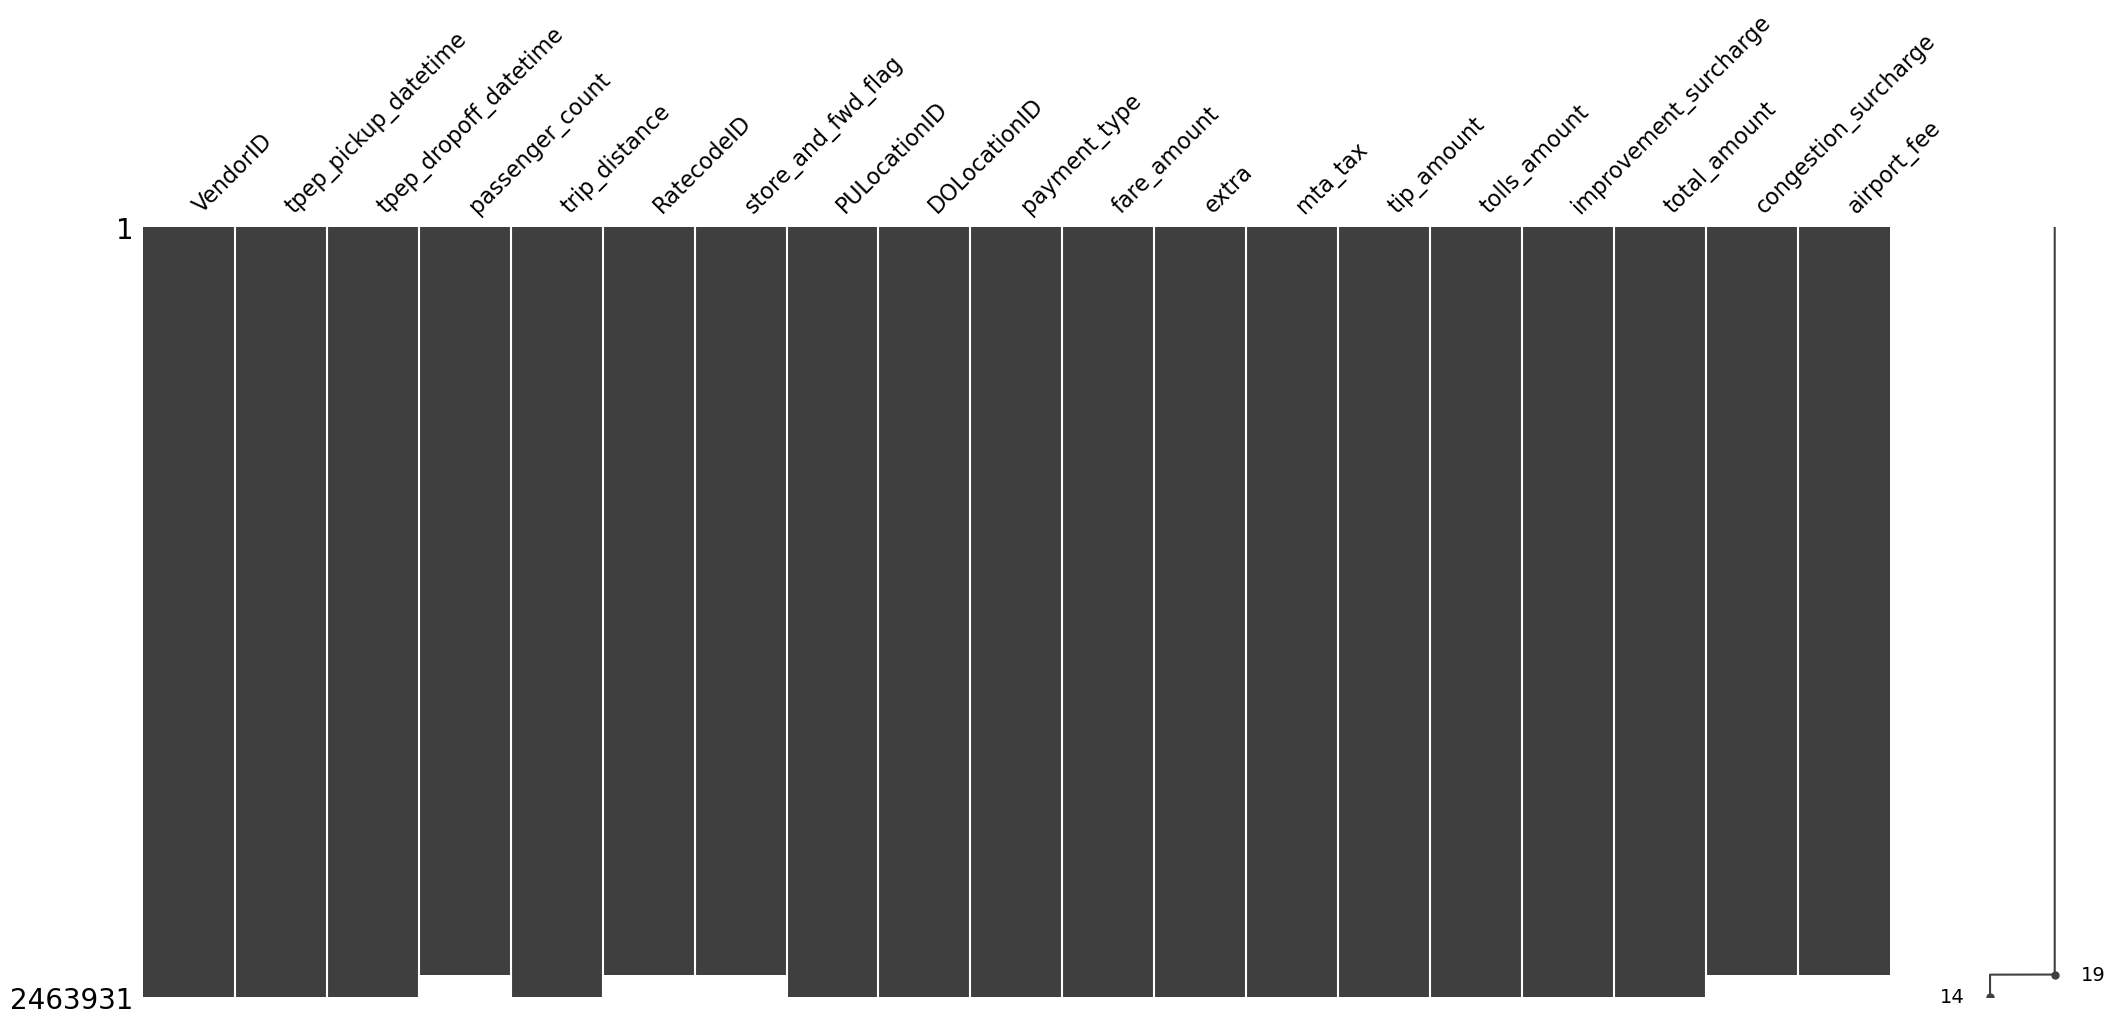

In [126]:
msno.matrix(df)

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463931 entries, 0 to 2463930
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

## Cool...because we used a parquet file, everything is already the right data type.  If we had used a .csv we would have had to set 'tpep_pickup_datetime'  to datetime with:

df['tpep_pickup_datetime'] = pd.to_datetime(df.tpep_pickup_datetime)

<AxesSubplot: >

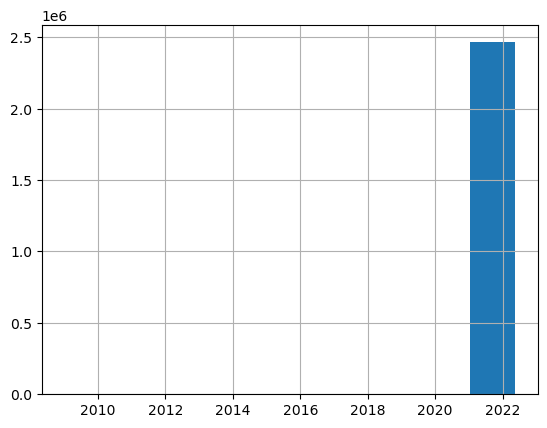

In [128]:
df.tpep_pickup_datetime.hist()

### Cool...we have an outlier situation.  Let's filter out everything that's not in 2022

In [129]:
len(df[(df.tpep_pickup_datetime.dt.year!=2022)|(df.tpep_pickup_datetime.dt.month!=1)])

52

### We're going to drop the 52 rows with pickup times that aren't in 2022

In [130]:
df = df[(df.tpep_pickup_datetime.dt.year==2022)&(df.tpep_pickup_datetime.dt.month==1)]

(array([18993., 18997., 19001., 19005., 19009., 19013., 19017., 19021.,
        19024.]),
 [Text(18993.0, 0, '2022-01-01'),
  Text(18997.0, 0, '2022-01-05'),
  Text(19001.0, 0, '2022-01-09'),
  Text(19005.0, 0, '2022-01-13'),
  Text(19009.0, 0, '2022-01-17'),
  Text(19013.0, 0, '2022-01-21'),
  Text(19017.0, 0, '2022-01-25'),
  Text(19021.0, 0, '2022-01-29'),
  Text(19024.0, 0, '2022-02-01')])

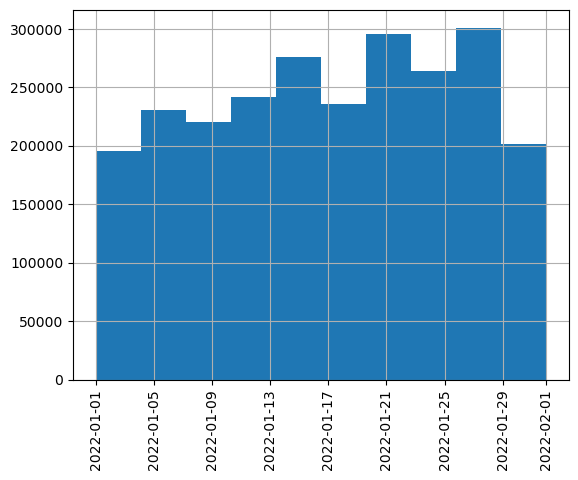

In [131]:
df.tpep_pickup_datetime.hist()
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Total Yellow Cab Ride Pickups by Hour\nJan 2022')

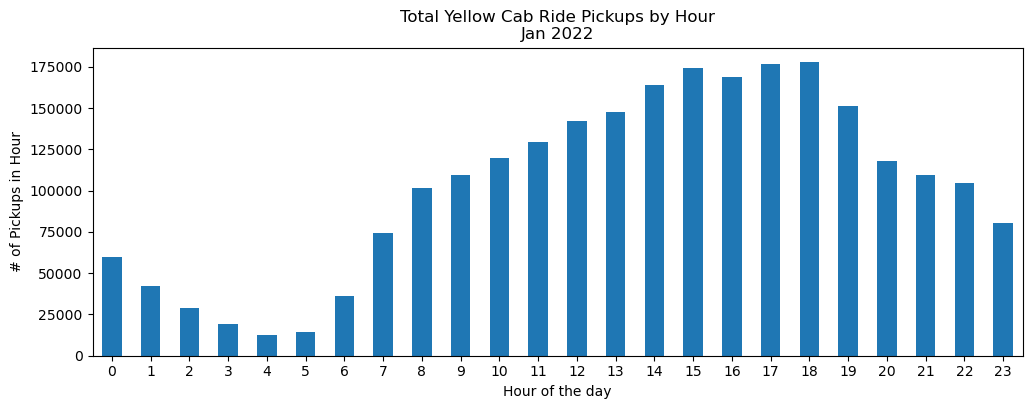

In [132]:
fig, axs = plt.subplots(figsize=(12, 4))


df.groupby(df["tpep_pickup_datetime"].dt.hour)["tpep_pickup_datetime"].count().plot(kind='bar', rot=0, ax=axs)


plt.xlabel("Hour of the day");  # custom x label using Matplotlib

plt.ylabel("# of Pickups in Hour")

plt.title('Total Yellow Cab Ride Pickups by Hour\nJan 2022')

# Brute force separate plots for each VendorID:

In [133]:
df.groupby(['VendorID',df["tpep_pickup_datetime"].dt.hour])["tpep_pickup_datetime"].count().max()

124930

In [144]:
df.groupby(['VendorID',df["tpep_pickup_datetime"].dt.hour])["tpep_pickup_datetime"].count()

VendorID  tpep_pickup_datetime
1         0                       16357
          1                       11514
          2                        7844
          3                        5190
          4                        3708
                                  ...  
6         19                        132
          20                        114
          21                         74
          22                         88
          23                         66
Name: tpep_pickup_datetime, Length: 85, dtype: int64

In [135]:
def roundup(x):
    return int(math.ceil(x / 10000.0)) * 10000

In [136]:
roundup(df.groupby(['VendorID',df["tpep_pickup_datetime"].dt.hour])["tpep_pickup_datetime"].count().max())

130000

In [152]:
pickup_frame = pd.DataFrame(df.groupby(['VendorID',df["tpep_pickup_datetime"].dt.hour])["tpep_pickup_datetime"].count()).rename(columns={'tpep_pickup_datetime':'pickup_count'}).reset_index()

In [154]:
pickup_frame.head()

,VendorID,tpep_pickup_datetime,pickup_count
0,1,0,16357
1,1,1,11514
2,1,2,7844
3,1,3,5190
4,1,4,3708


In [153]:
pickup_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   VendorID              85 non-null     int64
 1   tpep_pickup_datetime  85 non-null     int64
 2   pickup_count          85 non-null     int64
dtypes: int64(3)
memory usage: 2.1 KB


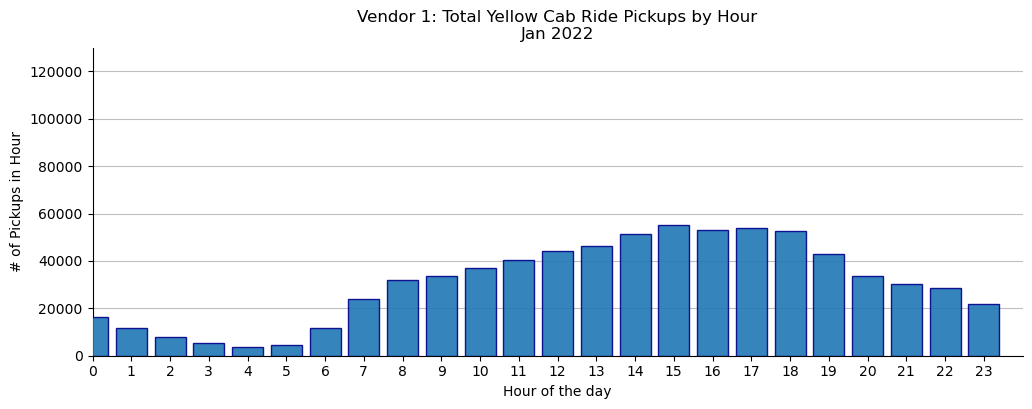

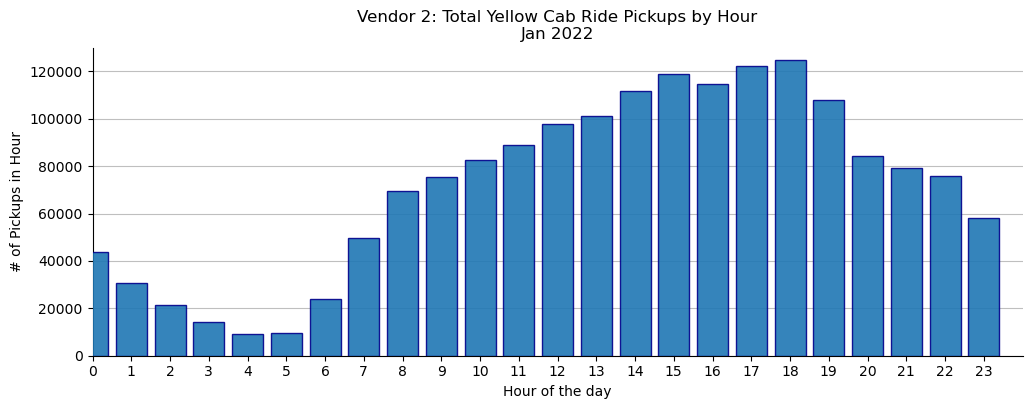

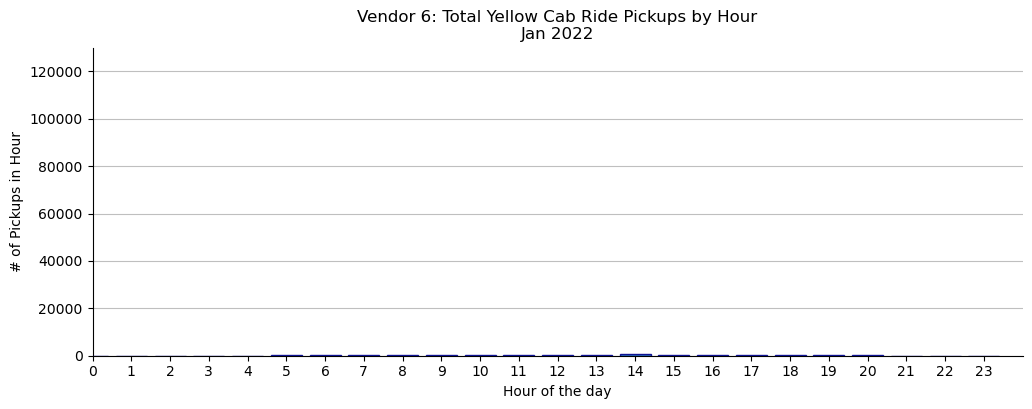

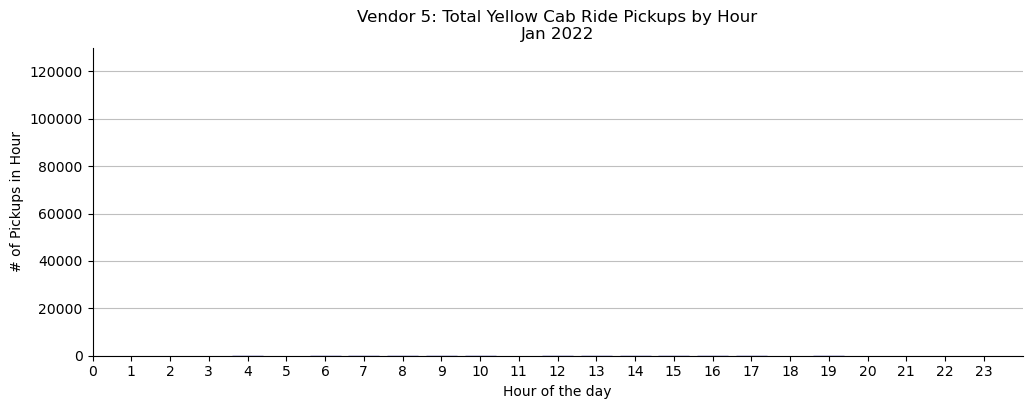

In [247]:
for vendor in df.VendorID.unique():
    
    visframe = pickup_frame[pickup_frame.VendorID==vendor]
    
    fig, axs = plt.subplots(figsize=(12, 4))
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    plt.grid(axis='y',alpha=.8,zorder=0)

    plt.bar(data=visframe,x='tpep_pickup_datetime',height='pickup_count',alpha=0.9,edgecolor='darkblue',zorder=3)

    plt.xlim(0,24)

    plt.xticks(np.arange(0, 24, 1.0))
    
    plt.xlabel("Hour of the day");  # custom x label using Matplotlib

    plt.ylabel("# of Pickups in Hour")
    
    plt.ylim(0,roundup(df.groupby(['VendorID',df["tpep_pickup_datetime"].dt.hour])["tpep_pickup_datetime"].count().max()))
    
    plt.title('Vendor ' + str(vendor) +': Total Yellow Cab Ride Pickups by Hour\nJan 2022')
    


In [227]:
# fig, axs = plt.subplots(len(df.VendorID.unique()),figsize=(12, 10),sharex=True, sharey=True)

# ct = 0
# for ax in axs:
#     vendor = df.VendorID.unique().tolist()[ct]
#     print(vendor)
#     visframe = pickup_frame[pickup_frame.VendorID == vendor]
    
#     g = plt.bar(data=visframe,x='tpep_pickup_datetime',height='pickup_count')

#     plt.xlim(0,24)

#     plt.xticks(np.arange(0, 24, 1.0))
    
#     plt.xlabel("Hour of the day");  # custom x label using Matplotlib

#     plt.ylabel("Number of Pickups");

#     ct +=1
    
# plt.title('Vendor ' + str(vendor) + ': NYC Yellow Cab Puckups by Hour of Day\nJan 2022')
